In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Stable diffusion

/content/drive/MyDrive/Stable diffusion


In [ ]:
import pandas as pd

fever_claims = pd.read_excel('only_fever_claims.xlsx')

In [ ]:
claims100k=(list(fever_claims['claim']))[0:101]

In [ ]:
prompts = claims100k # list of prompts to use for the remainder of the code

In [ ]:
len(prompts)

101

## Setup

In [ ]:
!pip install daam==0.0.11
!pip install accelerate  # this is to reduce CPU model load overhead

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.

In [ ]:
!nvidia-smi

Fri Feb 17 20:27:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from diffusers import StableDiffusionPipeline
import daam

In [ ]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to('cuda')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
import time
import torch
import random
import numpy as np
import os

In [ ]:
prompts

['Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
 'Roman Atwood is a content creator.',
 'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.',
 'Adrienne Bailon is an accountant.',
 'System of a Down briefly disbanded in limbo.',
 'Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.',
 'Beautiful reached number two on the Billboard Hot 100 in 2003.',
 'Neal Schon was named in 1954.',
 'The Boston Celtics play their home games at TD Garden.',
 'The Ten Commandments is an epic film.',
 'Tetris has sold millions of physical copies.',
 'Cyndi Lauper won the Best New Artist award at the 27th Grammy Awards in 1985.',
 'There is a movie called The Hunger Games.',
 'Ryan Gosling has been to a country in Africa.',
 'Stranger Things is set in Bloomington, Indiana.',
 'Ryan Seacrest is a person.',
 'Puerto Rico is not an unincorpo

In [ ]:
import PIL
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel



In [ ]:
from daam import GenerationExperiment, trace
model_id = 'stabilityai/stable-diffusion-2-base'
device = 'cuda'
from torch import autocast
def set_seed(seed):
  gen = torch.Generator(device='cuda')
  random.seed(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

def write_file(filename, intval):
    with open(filename, 'w') as fp:
        fp.write(str(intval))

def read_file(filename):
    with open(filename) as fp:
        return fp.read()

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

# prompt = 'Deepika Padukone buying liquor in Mumbai' # provide the prompt , iterate over the list of claims in fever and run the loop
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

def gen_image_daam(prompt, index):
  lst = []
  s = int(time.time())
  gen = set_seed(s)  # for reproducibility
  sample_num = 5
  if not os.path.exists(f'img_gen/{index}'):
    os.makedirs(f'img_gen/{index}')
  with daam.trace(pipe) as tc:
    for i in range(sample_num):
      with autocast("cuda"):
        a = pipe(prompt,num_inference_steps=100, generator=gen)['images'][0]
        lst.append(a)
        a.save(f'img_gen/{index}/gen-image-img-{i}-seed-{s}.png')
        exp = tc.to_experiment(f'img_gen/{index}/image_{i}')
        exp.save()  # experiment-dir now contains all the data and heat maps

      # exp = GenerationExperiment.load('experiment-dir-WillSmith7')  # load the experiment
  return lst

def get_clip_scores(prompt, lst):
  inputs = processor(text=prompt, images=lst, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
  best_image = max(logits_per_image)
  arg_max = torch.argmax(logits_per_image)
  return logits_per_image, best_image, arg_max
for i in range(len(prompts)):
  lst = gen_image_daam(prompts[i], i)
  logits_per_image, best_image, arg_max = get_clip_scores(prompts[i], lst)
  write_file(f'img_gen/{i}/best_image.txt', "All CLIP Scores: "+ str(logits_per_image) +" Best Image: image_" + str(int(arg_max)) + " with CLIP score of " + str(best_image))


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

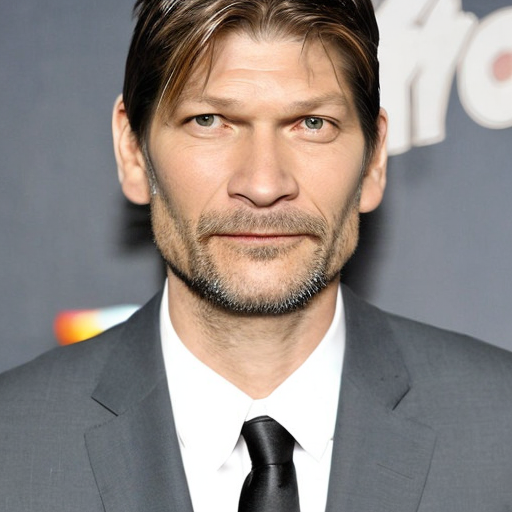

In [ ]:
lst[0]